In [1]:
%load_ext autoreload
%autoreload 2

import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

import weight_formats.experiments as E
import plot_utils

logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
    "figure.figsize": (5, 3),
})

2025-06-21:09:35:45,593 INFO     [rouge_scorer.py:83] Using default tokenizer.
2025-06-21:09:35:45,960 INFO     [_client.py:1025] HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


In [3]:
runs = E.runs("20250619-denoise-lr-sweep")
df = pd.DataFrame.from_records([
    dict(id=run.id,
         lr=run.config.lr,
         lr_schedule=run.config.lr_schedule,
         weight_decay=run.config.get("weight_decay", 0),
         adam_betas=tuple(run.config.get("adam_betas", (0.9, 0.999))),
         # Outcome
         loss=run.summary.train.loss[-1] if "train" in run.summary else None,
         valid_kl_div=run.summary.train.valid_kl_div[-1] if "train" in run.summary else None,
         steps=run.config.log_interval * (len(run.summary.train.loss)-1) if "train" in run.summary else None,
         duration_mins=run.meta.duration/60 if "duration" in run.meta else None,
    )
    for run in runs
])
df.sort_values("valid_kl_div").head()

,id,lr,lr_schedule,weight_decay,adam_betas,loss,valid_kl_div,steps,duration_mins
38,20250619-denoise-lr-sweep/5RGFPeqguW,3.814697e-06,linear,0.0,"(0.8, 0.9)",0.049648,0.044277,16384.0,331.023067
37,20250619-denoise-lr-sweep/4jA98mGNnM,3.814697e-06,linear,0.0,"(0.9, 0.95)",0.049709,0.044916,16384.0,330.887917
18,20250619-denoise-lr-sweep/hG3kkBj13T,3.814697e-06,linear,0.0,"(0.9, 0.999)",0.051785,0.045977,16384.0,331.277317
19,20250619-denoise-lr-sweep/8QFTHS5JLl,9.536743e-07,linear,0.0,"(0.9, 0.999)",0.063598,0.060197,16384.0,329.232067
29,20250619-denoise-lr-sweep/qs1W7QzBsZ,3.814697e-06,constant,0.0,"(0.8, 0.9)",0.086958,0.075458,1024.0,22.102738


## LR and decay

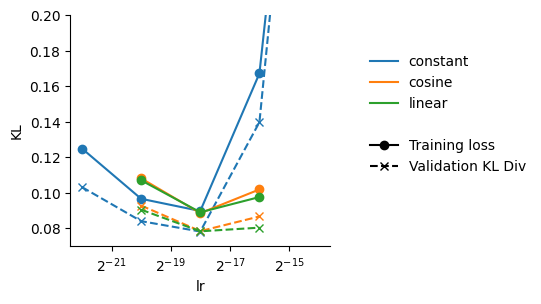

In [10]:
_, ax = plt.subplots()

palette = sns.color_palette()
schedules = [
    ("constant", dict(color=palette[0], label="constant")),
    ("cosine", dict(color=palette[1], label="cosine")),
    ("linear", dict(color=palette[2], label="linear")),
]
losses = dict(
    loss=dict(marker="o", label="Training loss"),
    valid_kl_div=dict(marker="x", ls="--", label="Validation KL Div"),
)

for schedule, sargs in schedules:
    d = df[(df.lr_schedule == schedule) & (df.steps == 1024) & (df.weight_decay == 0) & (df.adam_betas == (0.9, 0.999))].sort_values("lr")
    if len(d):
        ax.plot(d.lr, d.loss, **{**sargs, **losses["loss"]})
        ax.plot(d.lr, d.valid_kl_div, **{**sargs, **losses["valid_kl_div"]})

plot_utils.set_figure_legend(ax.figure, build=[*schedules, "", *losses.items()])
ax.set_xscale("log", base=2)
ax.set_ylim((0.07, 0.2))
ax.set_xlabel("lr")
ax.set_ylabel("KL");

## Weight Decay

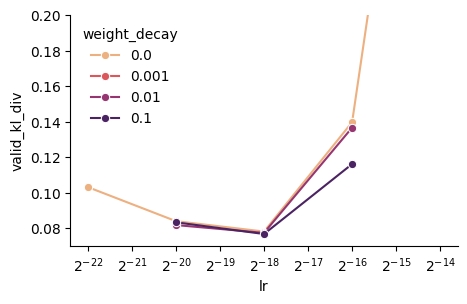

In [9]:
ax = sns.lineplot(data=df[(df.lr_schedule == "constant") & (df.steps == 1024) & (df.adam_betas == (0.9, 0.999))],
                  y="valid_kl_div", x="lr", hue="weight_decay", palette="flare", marker="o", hue_norm=matplotlib.colors.SymLogNorm(1e-3))
ax.set_xscale("log", base=2)
ax.set_ylim((0.07, 0.2));

## Adam Beta

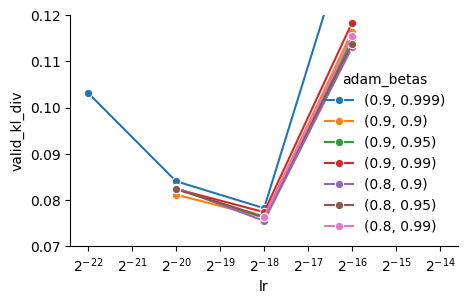

In [24]:
ax = sns.lineplot(data=df[(df.lr_schedule == "constant") & (df.steps == 1024) & (df.weight_decay == 0)],
                  y="valid_kl_div", x="lr", hue="adam_betas", marker="o")
ax.set_xscale("log", base=2)
ax.set_ylim((0.07, 0.12));

## Longer Runs

In [4]:
dft = pd.concat([
    pd.DataFrame.from_dict(dict(id=run.id, **run.summary.train, step=run.config.log_interval * torch.arange(len(run.summary.train.loss)))).assign(name=name)
    for name, key in dict(s1k="8yTEX4bTlB", s16k="hG3kkBj13T", s16k_lr20="8QFTHS5JLl", s16k_b9_95="4jA98mGNnM", s16k_b8="5RGFPeqguW").items()
    for run in [E.run(f"20250619-denoise-lr-sweep/{key}")]
]).reset_index(drop=True)
dft.head()

,id,duration,valid_cross_entropy,loss,valid_kl_div,step,name
0,20250619-denoise-lr-sweep/8yTEX4bTlB,NaN,2.402681,NaN,0.185965,0.0,s1k
1,20250619-denoise-lr-sweep/8yTEX4bTlB,1.299097,2.312325,0.141363,0.105873,64.0,s1k
2,20250619-denoise-lr-sweep/8yTEX4bTlB,1.137150,2.300623,0.110552,0.096199,128.0,s1k
3,20250619-denoise-lr-sweep/8yTEX4bTlB,1.132220,2.297055,0.112121,0.091948,192.0,s1k
4,20250619-denoise-lr-sweep/8yTEX4bTlB,1.137586,2.292274,0.102502,0.087942,256.0,s1k


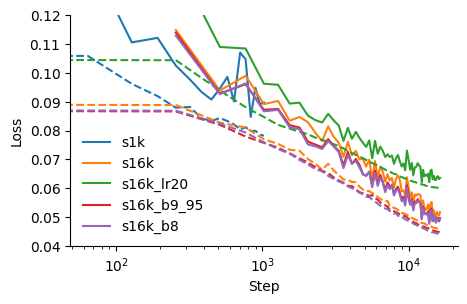

In [5]:
_, ax = plt.subplots()
for (name, g), color in zip(dft.groupby("name", sort=False), sns.color_palette()):
    ax.plot(g.step, g.loss, color=color, label=name)
    ax.plot(g.step, g.valid_kl_div, color=color, ls="--")
ax.set_xscale("log")
ax.set_ylim((0.04, 0.12))
ax.legend()
ax.set_xlabel("Step")
ax.set_ylabel("Loss");